# Assignmnet 3 (100 + 5 points)

**Name:** Jiahui Dai <br>
**Email:** jid4620@thi.de <br>
**Group:** B <br>
**Hours spend *(optional)* :** <br>

<h3> Submission </h3>

Submit your files in a zip file : firstname_lastname.zip. !!!

# Question 1: Word Embeddings (Word2Vec) *(30 points)*

Word2Vec is a popular technique in natural language processing (NLP) for learning vector representations of words, also known as word embeddings. These embeddings capture semantic relationships between words, such that words used in similar contexts are placed close to each other in the vector space.

There are two main architectures for Word2Vec:

- **Continuous Bag-of-Words (CBOW):** Predicts the current word based on its context (surrounding words).
- **Skip-Gram:** Predicts surrounding words given the current word.

In this tutorial, you will implement a simplified version of the Skip-Gram model using Python and train it on a given dataset.

---

## Your Task:

#### **Data Preparation:**

- Given a corpus of text (word2vec_dataset.en) attached, preprocess the data to create training examples suitable for a Skip-Gram model.
- Implement functions to tokenize the text, build a vocabulary, and generate input-output pairs for training.

#### **Implement a Simple Skip-Gram Model:**

- implement a simple neural network representing the Skip-Gram architecture.
- The model should learn word embeddings by training on the generated input-output pairs.

#### **Train the Model:**

- Train your Skip-Gram model on the prepared data.
- Use appropriate loss functions and optimization algorithms.

#### **Visualize Word Embeddings:**

- After training, visualize the learned word embeddings in 2D space using techniques like PCA or t-SNE.
- Plot the words to observe how similar words are positioned relative to each other.


#### **Notes:**

- If the training process is slow, consider reducing the size of the dataset to improve training speed.

### Allowed Libraries:
- **collections** for building vocabulary.
- **NumPy:** For numerical computations.
- **Matplotlib:** For plotting and visualization.
- **scikit-learn (sklearn):** For dimensionality reduction techniques like PCA or t-SNE, evaluation metrics.
- **TensorFlow or PyTorch** if you prefer to implement the model using these frameworks. However, since the challenge aims to be simple and educational, using NumPy suffices.




In [1]:
from collections import Counter, OrderedDict
import numpy as np
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Data preparation

In [2]:
def load_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()
    
    return content

In [3]:
# Data Preprocessing: Tokenization and cleaning
def preprocess(text):
    words = re.split(r"[^\w']+", text) # split content with non-alphabet into words
    words = [word.lower() for word in words if word.isalpha()] # make all words lower letter
    return words

In [4]:
class OrderedCounter(Counter, OrderedDict):
    '''To create an ordered counter'''

In [5]:
########################################
# Code reference:
# https://leshem-ido.medium.com/skip-gram-word2vec-algorithm-explained-85cd67a45ffa
########################################

def generate_context(tokens, vocab_to_id, context_window_size=2):
    """
    Generate input-output pairs (target, context) with context ranging from the context_window_size.
    Output pairs are in ids.

    Note: 
    This function uses the combined tokens, and context may spill over from previous/next sentences.    
    """

    context_target_pairs = []

    for i in range(context_window_size, len(tokens)-context_window_size):
        target = tokens[i]
        context = tokens[i-context_window_size : i+context_window_size+1]
        context.remove(target)

        for word in context:
            # context_target_pairs.append((target, word))
            context_target_pairs.append((vocab_to_id[target], vocab_to_id[word]))

    return context_target_pairs

In [6]:
# Load data file
data_folder = "data"
w2v_filepath = os.path.join(data_folder, "word2vec_dataset.en")

w2v_corpus = load_file(w2v_filepath)

# Build vocabulary list
words = preprocess(w2v_corpus)
w2v_bow = OrderedCounter(words)
w2v_vocab = set(w2v_bow.keys())
vocab_to_id = {word: idx for idx, word in enumerate(w2v_vocab)}
id_to_vocab = {idx: word for idx, word in enumerate(w2v_vocab)}

input_output_pairs = generate_context(words, vocab_to_id)

Implement simple Skip-Gram model

In [7]:
class SkipGramDataset(Dataset):

    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return torch.tensor(self.pairs[idx][0]), torch.tensor(self.pairs[idx][1])

In [8]:
class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center_words):
        embeds = self.embeddings(center_words)
        out = self.output(embeds)
        return out

Train model

In [9]:
# Hyperparameters
embedding_dim = 100
batch_size = 128
epochs = 5
learning_rate = 0.01

# Setup Dataset and Model
dataset = SkipGramDataset(input_output_pairs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = SkipGramModel(vocab_size=len(vocab_to_id), embedding_dim=embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for center, context in dataloader:
        optimizer.zero_grad()       # clears gradient from previous batch
        output = model(center)      # forward propagation
        loss = criterion(output, context)
        loss.backward()             # backpropagation
        optimizer.step()            # update model parameters
        total_loss += loss.item()   
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 5534.4131
Epoch 2/5, Loss: 4880.4062
Epoch 3/5, Loss: 4660.6366
Epoch 4/5, Loss: 4545.4862
Epoch 5/5, Loss: 4477.1831


Visualise word embeddings

In [10]:
def plot_words(reduced_dim, words_to_id, method):
    plt.figure(figsize=(15,10))
    for i, word in enumerate(words_to_id):
        x, y = reduced_dim[i]
        plt.scatter(x, y, color='grey')
        plt.annotate(word, (x, y), fontsize=8)
    plt.title(f"Word Embeddings Visualized with {method}")
    plt.grid(True)
    plt.show()

In [11]:
# Get embeddings
embeddings = model.embeddings.weight.data.cpu().numpy()

# Select a subset of words to visualize - 3744 words is too much to visualise
words_subset = list(vocab_to_id.keys())[:250]
words_subset_index = [vocab_to_id[word] for word in words_subset]
embedding_subset = embeddings[words_subset_index]

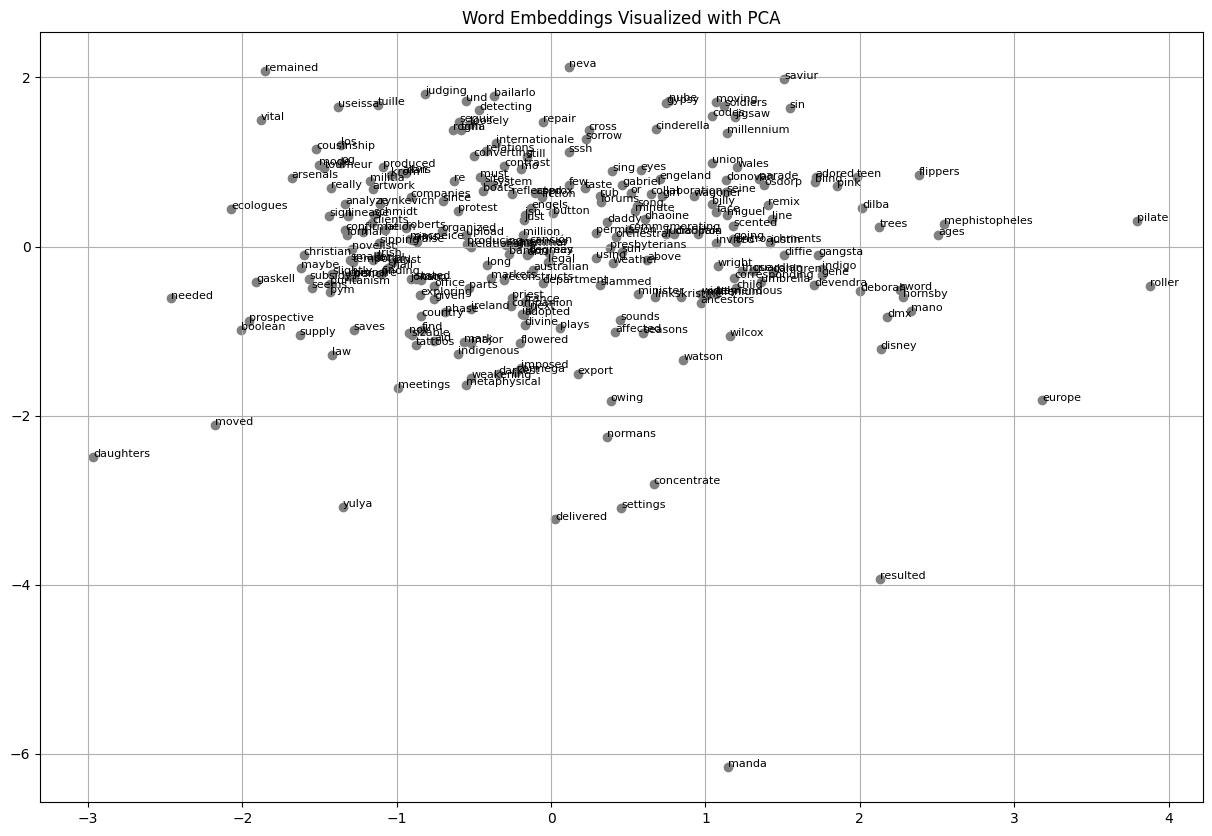

In [16]:
# PCA
reduced = PCA(n_components=2).fit_transform(embedding_subset)
plot_words(reduced, words_subset, 'PCA')

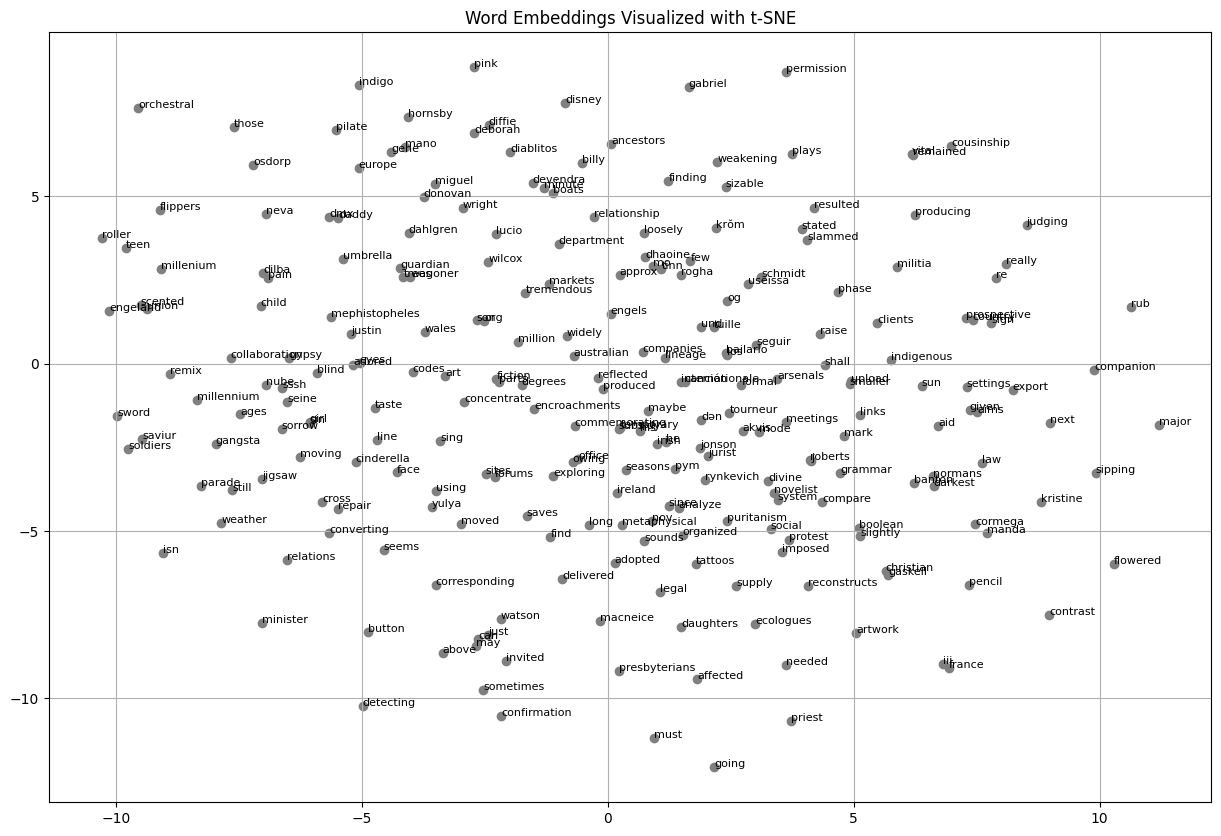

In [15]:
# t-SNE
reduced = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(embedding_subset)
plot_words(reduced, words_subset, 't-SNE')

Note: words with similar contexts are closer in the 2D space.  
PCA preserve global structure (variance) and is best for understanding variance directions.  
t-SNE preserve local structure and best for visualising clusters of similar points.

# Question 2: Transformer model *(70 points)*

As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set.

Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the train-validation loss curve). Write your findings and analysis in paragraphs.


**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In this case please add the dataset you used to the submission zip file.

In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.



## Notes:
1. You can also consider using a small subset of the dataset if the training dataset is large
2. Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3. Your training will be much faster if you use a GPU (Edit -> Notebook settings). If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)
4. It is a best practise to leverage vector representations learned in Q1 in your training as starting point for the embedding layer.




### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*